## Building the dataset that will be input into the model

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Building dataset").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_04_01")

DataFrame[]

In [2]:
import pyspark.pandas as ps
from pyspark.sql.functions import lit,col
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from CreateDataset import get_features_all_stocks_seq, get_full_series_stocks

/opt/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
full_series_stocks = get_full_series_stocks(df) #this gets the stocks that have data since 2001
filtered_df = df[df['fsym_id'].isin(full_series_stocks)]
filtered_df = get_features_all_stocks_seq(filtered_df) #get stocks that have data in the ff_advanced_der_af for all years, not just prices (or not even)
#for boruta, maybe treat each column separately 22*10 features?
filtered_df.show(10)

File found


/home/ztewari/Stock-Implosion-Prediction-FYP/CreateDataset.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_for_year'] = df['fsym_id'].map({k: list(generate_dates()) for k, g in df.groupby('fsym_id')})


+--------+----------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| fsym_id|ff_net_inc_bef_xord_gr|     ff_capex_assets|     ff_div_yld_secs|             ff_roic|         ff_earn_yld|ff_debt_st_x_curr_port|             ff_roce|      ff_oper_inc_gr|    ff_reinvest_rate|            ff_wkcap|  ff_commiss_inc_net| ff_oper_cf_fix_chrg|  ff_debt_entrpr_val|ff_net_inc_dil_bef_unusual|             ff_xord|        ff_xord_disc|      ff_liabs_lease|     ff_pfd_stk_tcap|        

Number of records:  4308
+--------+----------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| fsym_id|ff_net_inc_bef_xord_gr|     ff_capex_assets|     ff_div_yld_secs|             ff_roic|         ff_earn_yld|ff_debt_st_x_curr_port|             ff_roce|      ff_oper_inc_gr|    ff_reinvest_rate|            ff_wkcap|  ff_commiss_inc_net| ff_oper_cf_fix_chrg|  ff_debt_entrpr_val|ff_net_inc_dil_bef_unusual|             ff_xord|        ff_xord_disc|      ff_liabs_lease|    

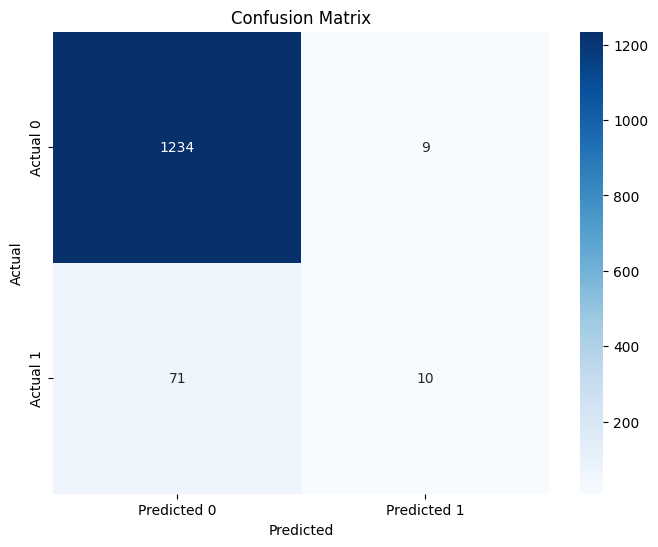

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def train_test_split(df):
    train, test = df.randomSplit([0.7,0.3], 22)
    return train, test


def confusion_matrix_pandas(df):
    df = df.toPandas()
    cm = confusion_matrix(df['label'], df['prediction'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


def model_testing(df):
    df = df.filter(reduce(lambda acc, column: acc & (F.size(col(column)) == 22), df.columns[1:-1], lit(True)))

    # average_lengths = df.agg(*[(F.avg(F.size(col(column))).alias(f'avg_length_{column}')) for column in df.columns[1:-1]])
    
    # test = padded_df.select('ff_non_oper_exp').filter(col('fsym_id')=='RTTY5P-R').collect()[0]
    # print(test['ff_non_oper_exp'], len(test['ff_non_oper_exp']))

    #need to decide whether to only include stocks that started from 2000, or include just from e.g. 2019
    #temporary measure - replace with 0
    #try imputer?
    #look into masking
    print("Number of records: ", df.count())
    features = df.columns[1:-1]
    list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
    for f in features:
        df = df.withColumn(f, list_to_vector_udf(f))
    df.show(2)
    train_df, test_df = train_test_split(df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)
    
    lr = LogisticRegression(featuresCol="features_vector", labelCol="label")

    # pipeline = Pipeline(stages=[vector_assembler, lr])
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

    evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

    crossval = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=5) 

    cvModel = crossval.fit(train_df)

    avg_metrics = cvModel.avgMetrics

    for i, acc in enumerate(avg_metrics):
        print(f"Fold {i + 1} - Validation Accuracy: {acc}")

    best_model = cvModel.bestModel

    predictions = best_model.transform(test_df)
    
    confusion_matrix_pandas(predictions.select('label', 'prediction'))
    
    
    
#     tp = predictions.filter((predictions.label == 1) & (predictions.prediction == 1)).count()
#     tn = predictions.filter((predictions.label == 0) & (predictions.prediction == 0)).count()
#     fp = predictions.filter((predictions.label == 0) & (predictions.prediction == 1)).count()
#     fn = predictions.filter((predictions.label == 1) & (predictions.prediction == 0)).count()
    
#     print(f"True Positives: {tp}")
#     print(f"True Negatives: {tn}")
#     print(f"False Positives: {fp}")
#     print(f"False Negatives: {fn}")

#     precision = tp / (tp + fp)
#     recall = tp / (tp + fn)
#     f1_score = 2 * (precision * recall) / (precision + recall)

#     print(f"Precision: {precision}")
#     print(f"Recall: {recall}")
#     print(f"F1 Score: {f1_score}")


def test_pandas(df1):
    df1 = df1.toPandas()
    exclude_columns = ['fsym_id', 'label']
    df = df1[df1.loc[:, ~df1.columns.isin(exclude_columns)].apply(lambda row: all(len(cell) == 23 for cell in row), axis=1)]
    print("Number of records: ", len(df))
    X = df.drop(exclude_columns, axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    lr = LogisticRegression()

    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [100, 200, 300]
    }

    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc')

    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_

    predictions = best_model.predict(X_test)

    auc = roc_auc_score(y_test, predictions)

    print(f"Area under the ROC curve (AUC): {auc}")
    print("Best model hyperparameters:")
    print(grid_search.best_params_)
    
    #extra_df= df[df.apply(lambda row: any(len(cell) != 23 for cell in row), axis=1)]
    
    
    
    
#create_dataset('FF_ADVANCED_DER_AF')

model_testing(filtered_df)
#test_pandas(df)

In [ ]:
#spark.sql("SELECT MIN(a.p_date) FROM fp_basic_prices a LEFT JOIN sym_ticker_region s ON s.fsym_id = a.fsym_id WHERE s.ticker_region = 'AACQU-US' ").show()

In [10]:
print(filtered_df.filter(F.col('label')==1).count())

255
